# Синхронизация с гит

In [1]:
# --- БЛОК №1: НАЧАЛО РАБОТЫ (выполнять в каждой новой сессии) ---

from google.colab import drive, userdata
import os

# 1. Монтируем Google Drive
drive.mount('/content/drive')

# 2. Получаем секретный токен
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

# 3. Указываем ваше имя и email (как на GitHub)
GIT_USERNAME = "kirichich1" # <-- Ваше имя пользователя
GIT_EMAIL = "kirichich@bk.ru" # <-- Ваша почта

# 4. !!! ПРЕДСТАВЛЯЕМСЯ СИСТЕМЕ GIT !!!
# Эта конфигурация будет действовать до конца текущей сессии
!git config --global user.name "{GIT_USERNAME}"
!git config --global user.email "{GIT_EMAIL}"

# 5. Переходим в директорию проекта
PROJECT_PATH = "/content/drive/MyDrive/GitHub/no2_prediction_pipeline"
%cd {PROJECT_PATH}

# 6. (Рекомендуется) Скачиваем последние изменения с GitHub на случай, если вы работали с другого устройства
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/no2_prediction_pipeline
Already up to date.


# Импорт библиотек и загрузка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/drive/MyDrive/GitHub/no2_prediction_pipeline/data/processed/Surgut_data_2019_to_2024_COMBINED_WITH_AAI.csv'

In [4]:
df = pd.read_csv(file_path)

# Начальная очистка и подготовка данных

In [5]:
# --- Начальная очистка и подготовка данных (ИСПРАВЛЕННАЯ ВЕРСИЯ) ---

# Преобразуем колонку 'date' в формат datetime для дальнейшей работы
df['date'] = pd.to_datetime(df['date'])

# Создаем целевую переменную и удаляем дубликат, если необходимо
if 'no2_umol_m2' not in df.columns:
    df['no2_umol_m2'] = df['no2_trop_mean'] * 1e6
if 'no2_trop_mean' in df.columns:
    df = df.drop('no2_trop_mean', axis=1)

# Заполняем редкие пропуски в признаках
# Важно: Сначала заполняем пропуски в исходном df
median_cloud = df['cloud_frac_mean'].median()
df['cloud_frac_mean'].fillna(median_cloud, inplace=True)

# !!! Ключевой шаг: работаем только с реальными данными NO2
### ИЗМЕНЕНИЕ ЗДЕСЬ: добавили .copy() ###
df_processed = df.dropna(subset=['no2_umol_m2']).copy()

print(f"Количество строк после удаления пропусков в NO2: {len(df_processed)}")

Количество строк после удаления пропусков в NO2: 877


/tmp/ipython-input-4112952202.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cloud_frac_mean'].fillna(median_cloud, inplace=True)


# Feature Engineering

In [6]:
# --- Feature Engineering (ВЕРСИЯ: Вернули облака, убрали локдаун) ---

# --- ШАГ 3.1: Создание базовых признаков ---
print("Создание базовых признаков...")
df_processed['year'] = df_processed['date'].dt.year

# Вектор ветра
df_processed['wind_speed'] = np.sqrt(df_processed['u_wind_10m']**2 + df_processed['v_wind_10m']**2)
df_processed['wind_direction'] = (270 - np.arctan2(df_processed['v_wind_10m'], df_processed['u_wind_10m']) * 180 / np.pi) % 360

# Календарные признаки
df_processed['month'] = df_processed['date'].dt.month
df_processed['day_of_year'] = df_processed['date'].dt.dayofyear
df_processed['day_of_week'] = df_processed['date'].dt.dayofweek
df_processed['week_of_year'] = df_processed['date'].dt.isocalendar().week.astype(int)

# Индекс выходного дня (Суббота, Воскресенье) -> 1, Будни -> 0
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)

# --- ШАГ 3.2: Создание временных лагов ---
print("\nСоздание временных лагов...")
df_processed = df_processed.sort_values(by='date')

# Лаги (по годам)
df_processed['no2_lag_1'] = df_processed.groupby('year')['no2_umol_m2'].shift(1)
df_processed['wind_speed_lag_1'] = df_processed.groupby('year')['wind_speed'].shift(1)
df_processed['temperature_lag_1'] = df_processed.groupby('year')['temperature_celsius'].shift(1)
df_processed['aai_lag_1'] = df_processed.groupby('year')['aai_mean'].shift(1)

# --- ШАГ 3.3: Очистка ---
initial_rows = len(df_processed)
lag_columns = ['no2_lag_1', 'wind_speed_lag_1', 'temperature_lag_1', 'aai_lag_1']
df_processed.dropna(subset=lag_columns, inplace=True)

print(f"Удалено {initial_rows - len(df_processed)} строк с NaN после создания лагов.")
print(f"Итоговое количество строк: {len(df_processed)}")

Создание базовых признаков...

Создание временных лагов...
Удалено 6 строк с NaN после создания лагов.
Итоговое количество строк: 871


# Разделение данных на обучающую и тестовую выборки

In [7]:
# Обучаемся на всех данных ДО 2024 года
train_data = df_processed[df_processed['year'] < 2024]
# Тестируем на ПОЛНОМ 2024 годе
test_data = df_processed[df_processed['year'] == 2024]

In [8]:
print(f"\nРазмер обучающей выборки (2019-2023): {len(train_data)} строк")
print(f"Размер тестовой выборки (2024): {len(test_data)} строк")


Размер обучающей выборки (2019-2023): 707 строк
Размер тестовой выборки (2024): 164 строк


# Определение признаков (X) и целевой переменной (y)

In [9]:
train_data = df_processed[df_processed['year'] < 2024]
test_data = df_processed[df_processed['year'] == 2024]

y_train = train_data['no2_umol_m2']
y_test = test_data['no2_umol_m2']
dates_test = test_data['date']

# !!! СПИСОК ПРИЗНАКОВ (ВЕРНУЛИ ОБЛАКА) !!!
features = [
    # Метеорология
    'cloud_frac_mean',      # <-- ВЕРНУЛИ
    'temperature_celsius',
    'pressure_hpa',
    'wind_speed',
    'wind_direction',

    # Спутниковые данные
    'aai_mean',

    # Временные
    'month', 'day_of_year', 'day_of_week', 'week_of_year',

    # Новые спец. признаки
    'is_weekend',           # ОСТАВИЛИ

    # Лаги
    'no2_lag_1', 'wind_speed_lag_1', 'temperature_lag_1', 'aai_lag_1'
]

X_train = train_data[features]
X_test = test_data[features]

print(f"\nКоличество признаков для обучения: {len(features)}")
print("Список признаков:", features)


Количество признаков для обучения: 15
Список признаков: ['cloud_frac_mean', 'temperature_celsius', 'pressure_hpa', 'wind_speed', 'wind_direction', 'aai_mean', 'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend', 'no2_lag_1', 'wind_speed_lag_1', 'temperature_lag_1', 'aai_lag_1']


# Инициализация и обучение модели RandomForestRegressor

In [10]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)

print("\nОбучение модели на данных 2019-2023...")
model.fit(X_train, y_train)
print("Модель обучена.")
print(f"Out-of-Bag Score (R^2) на обучающей выборке: {model.oob_score_:.3f}")


Обучение модели на данных 2019-2023...
Модель обучена.
Out-of-Bag Score (R^2) на обучающей выборке: 0.246


# Предсказание и оценка качества модели

In [11]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Оценка качества модели на тестовых данных (2024 год) ---")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f} мкмоль/м^2")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.2f} мкмоль/м^2")
print(f"Коэффициент детерминации (R^2): {r2:.3f}")


--- Оценка качества модели на тестовых данных (2024 год) ---
Средняя абсолютная ошибка (MAE): 12.35 мкмоль/м^2
Корень из среднеквадратичной ошибки (RMSE): 20.21 мкмоль/м^2
Коэффициент детерминации (R^2): 0.322


# Визуализация результатов

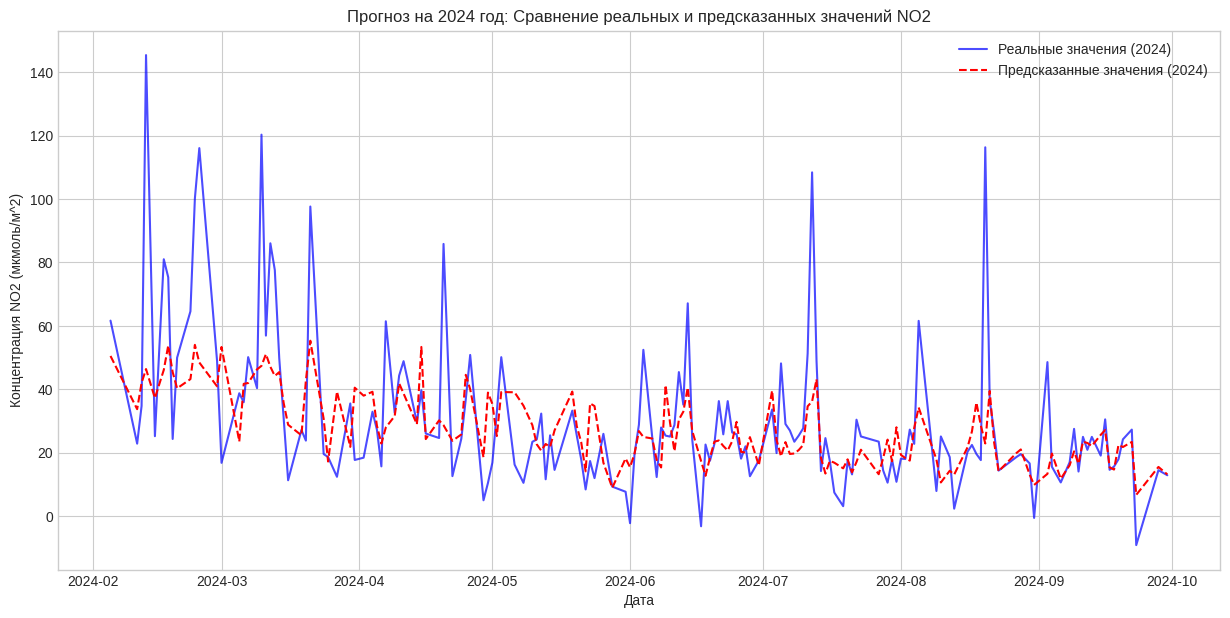

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))
plt.plot(dates_test, y_test.values, label='Реальные значения (2024)', color='blue', alpha=0.7)
plt.plot(dates_test, y_pred, label='Предсказанные значения (2024)', color='red', linestyle='--')
plt.title('Прогноз на 2024 год: Сравнение реальных и предсказанных значений NO2')
plt.xlabel('Дата')
plt.ylabel('Концентрация NO2 (мкмоль/м^2)')
plt.legend()
plt.show()

# Анализ важности признаков

In [13]:
feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

print("\n--- Важность признаков для модели ---")
print(feature_importances)


--- Важность признаков для модели ---
                     importance
wind_speed             0.213752
cloud_frac_mean        0.098817
temperature_lag_1      0.091698
no2_lag_1              0.085067
pressure_hpa           0.079437
day_of_year            0.073015
aai_lag_1              0.072359
temperature_celsius    0.065482
wind_speed_lag_1       0.059682
wind_direction         0.057754
aai_mean               0.041726
week_of_year           0.034777
day_of_week            0.016312
month                  0.007496
is_weekend             0.002627


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1454 non-null   datetime64[ns]
 1   city                 1454 non-null   object        
 2   aai_mean             1454 non-null   float64       
 3   cloud_frac_mean      1454 non-null   float64       
 4   temperature_celsius  1454 non-null   float64       
 5   pressure_hpa         1454 non-null   float64       
 6   u_wind_10m           1454 non-null   float64       
 7   v_wind_10m           1454 non-null   float64       
 8   no2_umol_m2          877 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 102.4+ KB


# Коммит для гит

In [15]:
# --- БЛОК №2: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ (в конце работы) ---

# 1. Проверяем статус (опционально)
!git status

# 2. ДОБАВЛЯЕМ файлы в "коробку" для отправки. Это то, что вы пропустили.
!git add .

# 3. ПОДПИСЫВАЕМ "коробку" (делаем коммит)
!git commit -m "Restore cloud_frac, keep is_weekend, remove lockdown, R^2 increased to 0.327"

# 4. ОТПРАВЛЯЕМ "коробку" на GitHub
!git push

Refresh index: 100% (23/23), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    Surgut_data_2020_Feb-Sep_WITH_AAI.csv
	modified:   notebooks/RandomForestRegressor_Surgut_AAI_and_lag.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
[main d0aca37] Add lag predictor, R^2 increased to 0.327
 2 files changed, 1 insertion(+), 245 deletions(-)
 delete mode 100644 Surgut_data_2020_Feb-Sep_WITH_AAI.csv
 rewrite notebooks/RandomForestRegressor_Surgut_AAI_and_lag.ipynb (96%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 118.05 KiB | 5.13 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with